# Tutorial 21: Symplectic integrators and ODEs

## PHYS 5070, Spring 2022

In [1]:
## Common import cell!

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## T21.1 - Stability of circular motion

For the tutorial, let's do an example which is only slightly more complicated than the SHO: circular motion in two dimensions due to a constant central force.  The equations of motion are

\\[
m \ddot{\vec{r}} = -F \hat{r}.
\\]

or splitting into two-dimensional Cartesian,

\\[
\begin{cases}
\ddot{x} &= -\frac{F}{m} \frac{x}{r}, \\
\ddot{y} &= -\frac{F}{m} \frac{y}{r}.
\end{cases}
\\]

Circular motion requires the force to satisfy the centripetal formula $F = mv^2 / r$.  Once again we only care about qualitative results, so let's just set $r_0 = v_0 = 1$, in which case we must also have $F/m = 1$.

(Note that we don't need an explicit Hamiltonian formulation here: we can just think in terms of velocity and position updates instead of momentum and position updates, and in this simple case there is no difference.)

### Part A

For the simplest approach, we use Euler's method, which leads to four discrete equations:
\\[
v_{x,i+1} = v_{x,i} -\frac{F dt}{m} \frac{x_i}{\sqrt{x_i^2 + y_i^2}} \\
v_{y,i+1} = v_{y,i} -\frac{F dt}{m} \frac{y_i}{\sqrt{x_i^2 + y_i^2}} \\
x_{i+1} = x_i + dt v_{x,i} \\
y_{i+1} = y_i + dt v_{y,i}
\\]

__Implement the function `euler_circle(t)` below__, which should take an array of $t$-values to solve over and return the solutions for `x(t), y(t), E(t)` as arrays of the same length.  (The potential energy function giving this force is $U(\vec{r}) = Fr$.)  I've given you some of the setup code already; just fill in the Euler loop and the energy calculation.

In [2]:
def euler_circle(t):
    
    dt = t[1] - t[0] 
    N = len(t)
    
    x_sol = np.zeros_like(t)
    y_sol = np.zeros_like(t)
    
    vx_sol = np.zeros_like(t)
    vy_sol = np.zeros_like(t)
    
    x_sol[0] = 1.0
    vy_sol[0] = 1.0 
    F_ov_m = 1.0

    ### BEGIN SOLUTION    
    for i in range(0, N-1):
        ri = np.sqrt(x_sol[i]**2 + y_sol[i]**2)
        
        x_sol[i+1] = x_sol[i] + dt * vx_sol[i]
        y_sol[i+1] = y_sol[i] + dt * vy_sol[i]
        vx_sol[i+1] = vx_sol[i] - F_ov_m * dt * x_sol[i] / ri
        vy_sol[i+1] = vy_sol[i] - F_ov_m * dt * y_sol[i] / ri
        
    E_sol = 0.5 * (vx_sol**2 + vy_sol**2) + F_ov_m * np.sqrt(x_sol**2 + y_sol**2)

    ### END SOLUTION    
    return x_sol, y_sol, E_sol



Now __run the cell below__ to make a scatter plot of the trajectory in real space for $t = 50$ and $dt = 0.01$.  You should see something that is _close_ to circular motion, but with some spiraling indicating a lack of energy conservation.  (As we discussed in lecture the violation of $\Delta E = 0$ is positive definite, so the spiral should be _outwards._

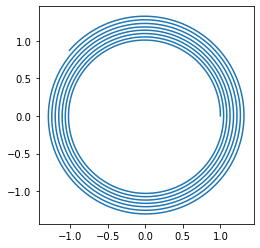

In [3]:
t = np.linspace(0,50,5000)
xs, ys, Es = euler_circle(t)

plt.plot(xs,ys)
ax = plt.gca()
ax.set_aspect(1)

Confirm explicitly that total energy is not conserved by __plotting $E(t)$ in the cell below.__  (You can also plot $r(t)$ to see the rate of increase of the orbital radius; the trends will be similar.)

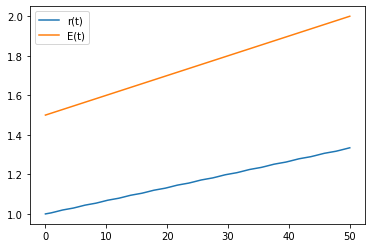

In [4]:
# We see r changing with time, as well as total energy:

rt = np.sqrt(xs**2 + ys**2)
plt.plot(t, rt, label='r(t)')
plt.plot(t, Es, label='E(t)')
plt.legend()

### Part B

We can improve the situation by making the step size smaller, of course.  In fact, we can predict how things will change in terms of energy: in lecture we saw the theoretical prediction that $\Delta E \propto t\ dt$.  __Use your simulation to verify this scaling relation__.

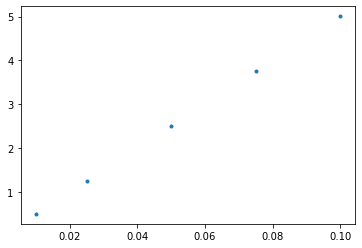

In [5]:
dt_array = [0.1, 0.075, 0.05, 0.025, 0.01]
Ef_array = []
for dt in dt_array:
    t = np.linspace(0, 50, int(50/dt))
    xs, ys, Es = euler_circle(t)
    Ef_array.append(Es[-1] - 1.5)
    
# This shows an obvious linear scaling with dt
plt.plot(dt_array, Ef_array, linestyle=' ', marker='.')  

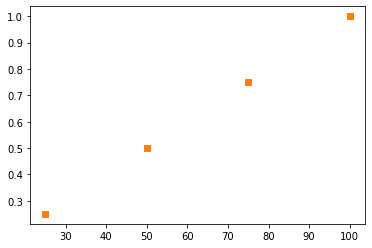

In [6]:
tmax_array = [25, 50, 75, 100]
Ef_array = []
for tmax in tmax_array:
    t = np.linspace(0, tmax, int(tmax/0.01))
    xs, ys, Es = euler_circle(t)
    Ef_array.append(Es[-1] - 1.5)

# Once again, obviously linear in tmax at fixed dt.
plt.plot(tmax_array, Ef_array, linestyle=' ', marker='s', color='C1')

What step size $dt$ would you need to evolve this system for $t = 50$ with a final error in energy of order $10^{-2}$?  (You can try it out to verify in the code cell below.)

The slope from our plot above at fixed $t=50$ in the relation $\Delta E = b dt$ is about $(4-3) / (0.075 - 0.05) = 1 / 0.025 = 40$.  So we'd need a step size of $dt = 2.5 \times 10^{-3}$, which means 200k steps.  Below I test this out - for just eyeballing the slope of the plot, it's about right.  But that's a lot of steps even for a 1 percent error!

0.012500067493403044

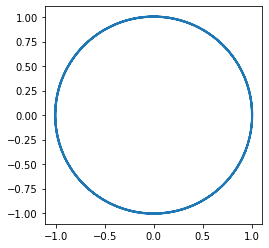

In [7]:
t = np.linspace(0,50,200000)
xs, ys, Es = euler_circle(t)

plt.plot(xs,ys)
ax = plt.gca()
ax.set_aspect(1)
Es[-1] - 1.5

### Part C

Now let's try a symplectic integrator to see what a difference it can make for energy conservation.  Symplectic Euler is too easy, so we'll implement one of the __leapfrog__ variants, where the update step takes the form
\\[
y(t + dt) = e^{(dt/2) \hat{T}} e^{dt \hat{V}} e^{(dt/2) \hat{T}} y(t).
\\]

(this specific version is sometimes called the QPQ leapfrog - switching $\hat{T}$ and $\hat{V}$ would give the PQP leapfrog.)


In other words:
- Update positions by $dt/2$, using the velocities;
- Update velocities by $dt$, using the half-updated positions;
- Update positions by $dt/2$ once more, using the fully updated velocities.

Each update is a simpler Euler step for the one set of variables being updated, as we discussed in lecture.  __Implement the `leapfrog_circle(t)` function below__, which is identical to `euler_circle` in terms of inputs and outputs but uses the QPQ leapfrog algorithm instead.  (A good start would be to copy the contents of your `euler_circle` implementation, in fact, since a lot of the setup is the same.)

In [8]:
def leapfrog_circle(t):
    dt = t[1] - t[0] 
    N = len(t)
    
    x_sol = np.zeros_like(t)
    y_sol = np.zeros_like(t)
    
    vx_sol = np.zeros_like(t)
    vy_sol = np.zeros_like(t)
        
    x_sol[0] = 1.0
    vy_sol[0] = 1.0 
    F_ov_m = 1.0
 
    ### BEGIN SOLUTION
    for i in range(0, N-1):
        
        x_half = x_sol[i] + dt * vx_sol[i] / 2
        y_half = y_sol[i] + dt * vy_sol[i] / 2
        r_half = np.sqrt(x_half**2 + y_half**2)
        
        vx_sol[i+1] = vx_sol[i] - F_ov_m * dt * x_half / r_half
        vy_sol[i+1] = vy_sol[i] - F_ov_m * dt * y_half / r_half
        
        x_sol[i+1] = x_half + dt * vx_sol[i+1] / 2
        y_sol[i+1] = y_half + dt * vy_sol[i+1] / 2
                
    E_sol = 0.5 * (vx_sol**2 + vy_sol**2) + F_ov_m * np.sqrt(x_sol**2 + y_sol**2)
    ### END SOLUTION
    return x_sol, y_sol, E_sol


Now __run the following cells__ to compare how leapfrog compares to symplectic Euler.  You should see enormously better performance in stability of the orbit, with no change in step size at all!

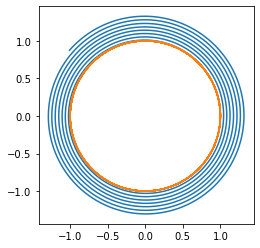

In [9]:
t = np.linspace(0,50,5000)
xs, ys, Es = euler_circle(t)
xL, yL, EL = leapfrog_circle(t)

plt.plot(xs,ys, label='Euler')
plt.plot(xL,yL, label='Leapfrog')
ax = plt.gca()
ax.set_aspect(1)

(0.99999, 1.00001)

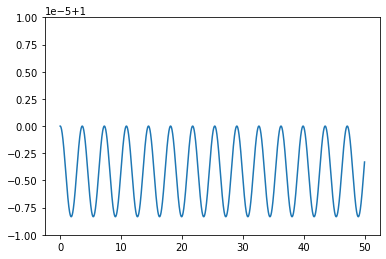

In [10]:
rL = np.sqrt(xL**2 + yL**2)
plt.plot(t, rL)
plt.ylim(0.99999,1.00001)

### Part D (optional)

We can obtain improved versions of symplectic integrators by breaking apart the position and velocity steps in different ways, with the goal of minimizing the deviation between the shadow Hamiltonian and the regular one.  The leapfrog algorithms already represent a significant improvement over symplectic Euler, with the shadow Hamiltonian differing from the regular one by $\mathcal{O}(dt^2)$.

A further improvement is given by the __Omelyan__ integrator schemes.  For example, the __Omelyan SST__ algorithm is given by the decomposition

\\[
y(t + dt) = e^{(dt/6) \hat{V}} e^{(dt/2) \hat{T}} e^{(2dt/3) \hat{V}} e^{(dt/2) \hat{T}} e^{(dt/6) \hat{V}} y(t).
\\]

Implement the Omelyan SST integrator for this problem below, and compare its error scaling to your leapfrog integrator.

In [11]:
def omelyan_circle(t):
    dt = t[1] - t[0] 
    N = len(t)
    
    ### BEGIN SOLUTION
    # Pending full solution, ran out of time...
    x_sol = np.zeros_like(t)
    y_sol = np.zeros_like(t)
    
    vx_sol = np.zeros_like(t)
    vy_sol = np.zeros_like(t)
    
    # Track total energy vs. time
    E_sol = np.zeros_like(t)
    
    x_sol[0] = 1.0
    vy_sol[0] = 1.0 
    F_ov_m = 1.0
    
    for i in range(0, N-1):
        
        ## V dt/6
        r = np.sqrt(x_sol[i]**2 + y_sol[i]**2)
        vx = vx_sol[i] - F_ov_m * dt / 6 * x_sol[i] / r
        vy = vy_sol[i] - F_ov_m * dt / 6 * y_sol[i] / r
        
        ## T dt/2
        x = x_sol[i] + dt * vx / 2
        y = y_sol[i] + dt * vy / 2
        r = np.sqrt(x**2 + y**2)
        
        ## V (2 dt / 3)
        vx = vx - F_ov_m * 2 * dt / 3 * x / r
        vy = vy - F_ov_m * 2 * dt / 3 * y / r
        
        ## T dt/2; final position update
        x_sol[i+1] = x + dt * vx / 2
        y_sol[i+1] = y + dt * vy / 2
        r = np.sqrt(x_sol[i+1]**2 + y_sol[i+1]**2)
        
        ## V dt/6; final velocity update
        vx_sol[i+1] = vx - F_ov_m * dt / 6 * x_sol[i+1] / r
        vy_sol[i+1] = vy - F_ov_m * dt / 6 * y_sol[i+1] / r
                
    E_sol = 0.5 * (vx_sol**2 + vy_sol**2) + F_ov_m * np.sqrt(x_sol**2 + y_sol**2)
    return x_sol, y_sol, E_sol
    ### END SOLUTION

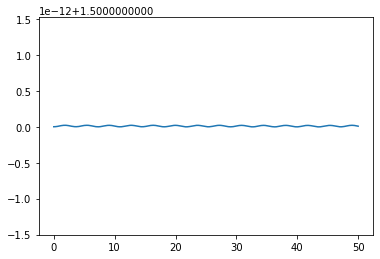

In [24]:
t = np.linspace(0,50,500)
xL, yL, EL = leapfrog_circle(t)
xo, yo, Eo = omelyan_circle(t)

#plt.plot(t, EL)
plt.plot(t, Eo)

This is an _extremely_ tiny error compared to leapfrog for this problem - in fact, the error in energy is about $10^{-6}$ times smaller for the Omelyan integrator with $dt = 0.1$!  In general, Omelyan is supposed to be __fourth-order__, which should mean the errors are around $dt^4$.  I think there must be some extra cancellation in this particular problem to make the Omyelan errors end up being so especially small.

In [13]:
print(np.max(Eo-1.5))
np.max(EL-1.5)

2.042810365310288e-14


1.0510315497924694e-06